# [E-09] X-ray 이미지를 사용한 폐렴진단

## Step 1. 실험환경 Set-up

In [24]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings(action='ignore')

In [61]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# BATCH_SIZE 변수
BATCH_SIZE = 16

# EPOCH 크기 변수
EPOCHS = 25

## Step 2. 데이터 준비하기

In [62]:
# 데이터 경로 변수 저장
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

TRAIN_PATH = ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/train/*/*'
VAL_PATH = ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/val/*/*'
TEST_PATH = ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/test/*/*'

In [63]:
# 경로내 파일제목 읽어들이기, tf.io.gfile.glob()를 사용하여 경로를 뽑아서 각각의 변수에 list 형으로 저장한다.
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 개수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [64]:
# train 데이터와 validation 데이터 합치기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

In [29]:
# 합친 개수 확인
len(filenames)

5232

In [65]:
# train, validation dataset으로 분할.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, shuffle=True, stratify=None, random_state=34)
#train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

# 재 분할된 데이터 수 확인
print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [66]:
# 정상이미지와 폐렴이미지의 수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


In [67]:
# tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, val dataset 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT)) # 4185

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT)) # 1047

# label 이름 확인
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/train/*')])
print(CLASS_NAMES) # ['PNEUMONIA' 'NORMAL']

Training images count: 4185
Validating images count: 1047
['NORMAL' 'PNEUMONIA']


In [68]:
# label data 생성
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [69]:
# 이미지 데이터 타입 float로 변경 후 resize
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [70]:
# train, val dataset 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지 확인
for image, label in train_ds.take(3): # take(1) 하나의 데이터만 가져오기
    print("Image shape: ", image.numpy().shape) # (180, 180, 3)
    print("Label: ", label.numpy()) # True

# testset 생성
test_list_ds = tf.data.Dataset.list_files(ROOT_PATH + '/workplace/EX09_Diagnosis_of_Pneumonia/data/train/*/*')
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT) # 624

Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
5216


In [55]:
# tf.data 파이프라인 사용
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

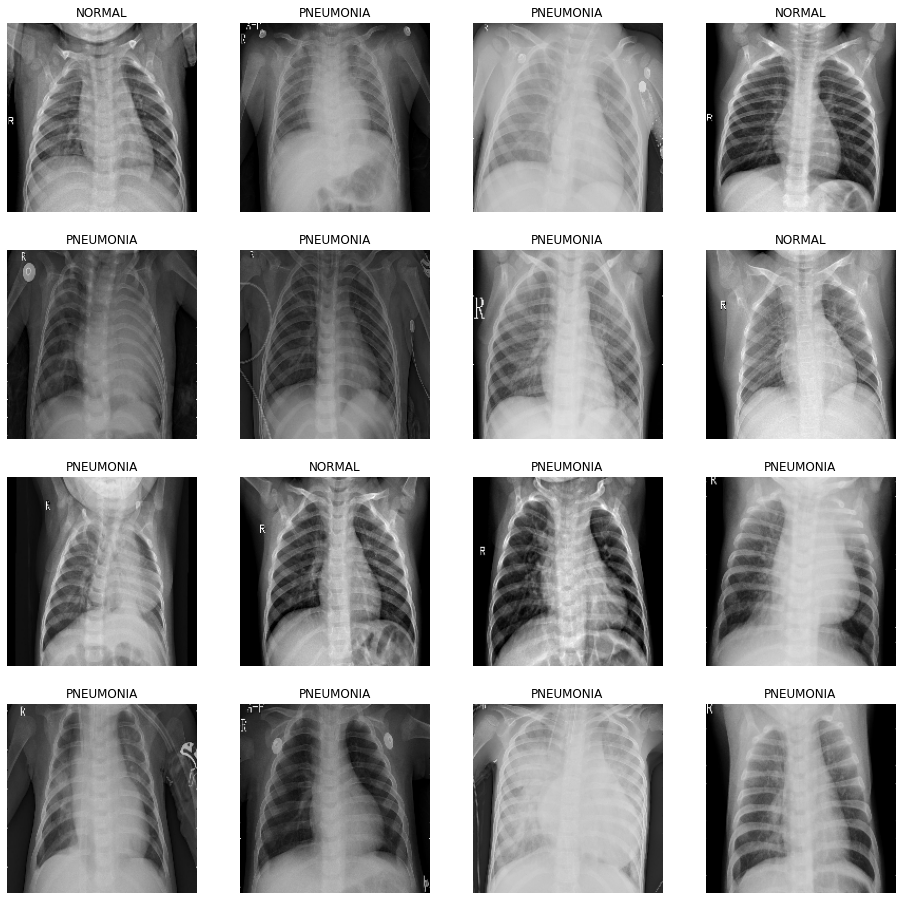

In [56]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [73]:
# Conv Layer
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [74]:
# Dense Layer
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [75]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [76]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


## Step 6. 모델 훈련

In [98]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 100s 216ms/step - loss: 0.4214 - accuracy: 0.8032 - precision: 0.9494 - recall: 0.7774 - val_loss: 0.7638 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 54s 206ms/step - loss: 0.2359 - accuracy: 0.9124 - precision: 0.9744 - recall: 0.9060 - val_loss: 1.2752 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 54s 207ms/step - loss: 0.2088 - accuracy: 0.9205 - precision: 0.9776 - recall: 0.9141 - val_loss: 0.3215 - val_accuracy: 0.8385 - val_precision: 0.8192 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 55s 211ms/step - loss: 0.1873 - accuracy: 0.9284 - precision: 0.9779 - recall: 0.9249 - val_loss: 0.1473 - val_accuracy: 0.9423 - val_precision: 0.9972 - val_recall: 0.9236
Epoch 5/25
261/261 [==============================] - 56s 216ms/step - loss: 0.1771 - accur

## Step 7. 결과 확인과 시각화

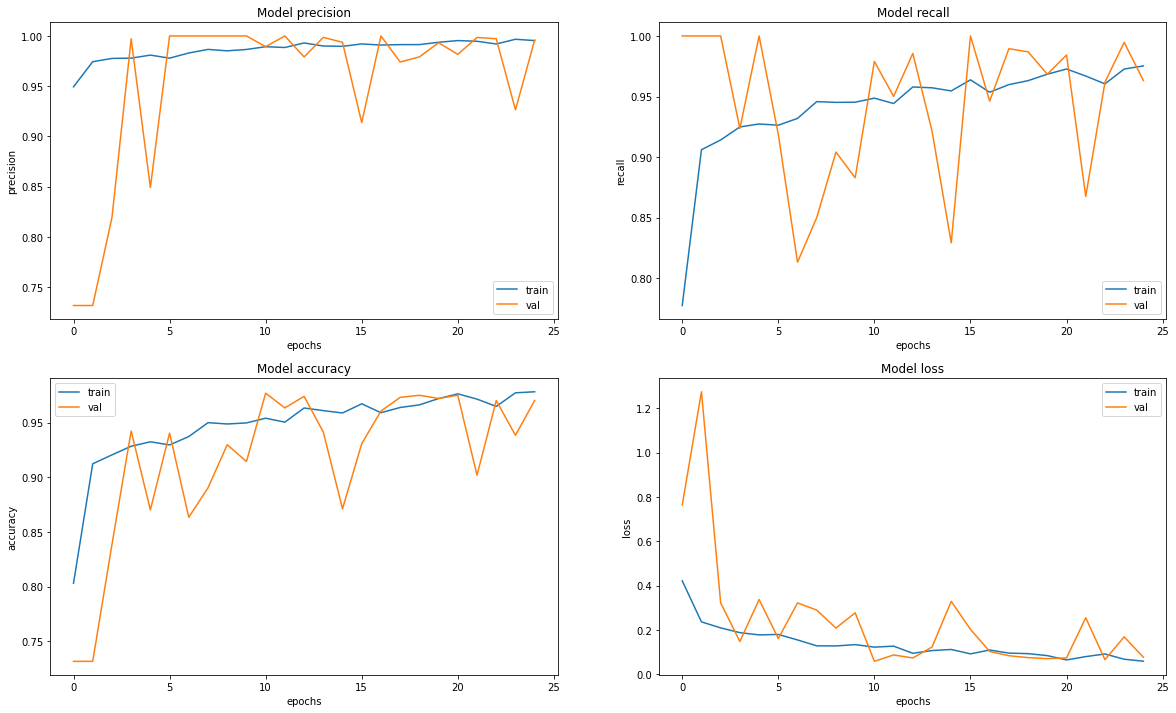

In [99]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [100]:
loss, acc, prec, rec = model.evaluate(test_ds)

326/326 [==============================] - 35s 108ms/step - loss: 0.0423 - accuracy: 0.9849 - precision: 0.9992 - recall: 0.9804


## Augmentation기법 사용

In [71]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

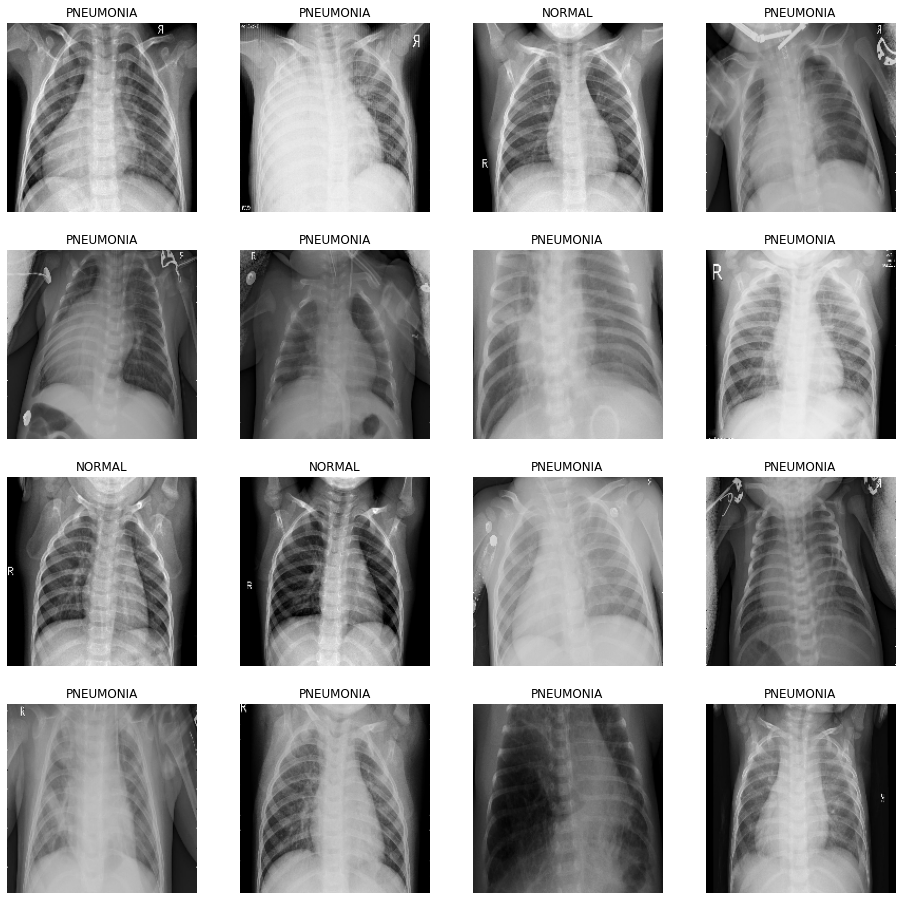

In [72]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())


image_batch, label_batch = next(iter(train_ds))

In [77]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [78]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 87s 192ms/step - loss: 0.4061 - accuracy: 0.7948 - precision: 0.9551 - recall: 0.7601 - val_loss: 0.7138 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2215 - accuracy: 0.9116 - precision: 0.9763 - recall: 0.9032 - val_loss: 1.3266 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2387 - accuracy: 0.9045 - precision: 0.9692 - recall: 0.9003 - val_loss: 0.5597 - val_accuracy: 0.7663 - val_precision: 0.7592 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1938 - accuracy: 0.9291 - precision: 0.9792 - recall: 0.9243 - val_loss: 0.0840 - val_accuracy: 0.9683 - val_precision: 0.9778 - val_recall: 0.9791
Epoch 5/25
261/261 [==============================] - 53s 202ms/step - loss: 0.1759 - accura

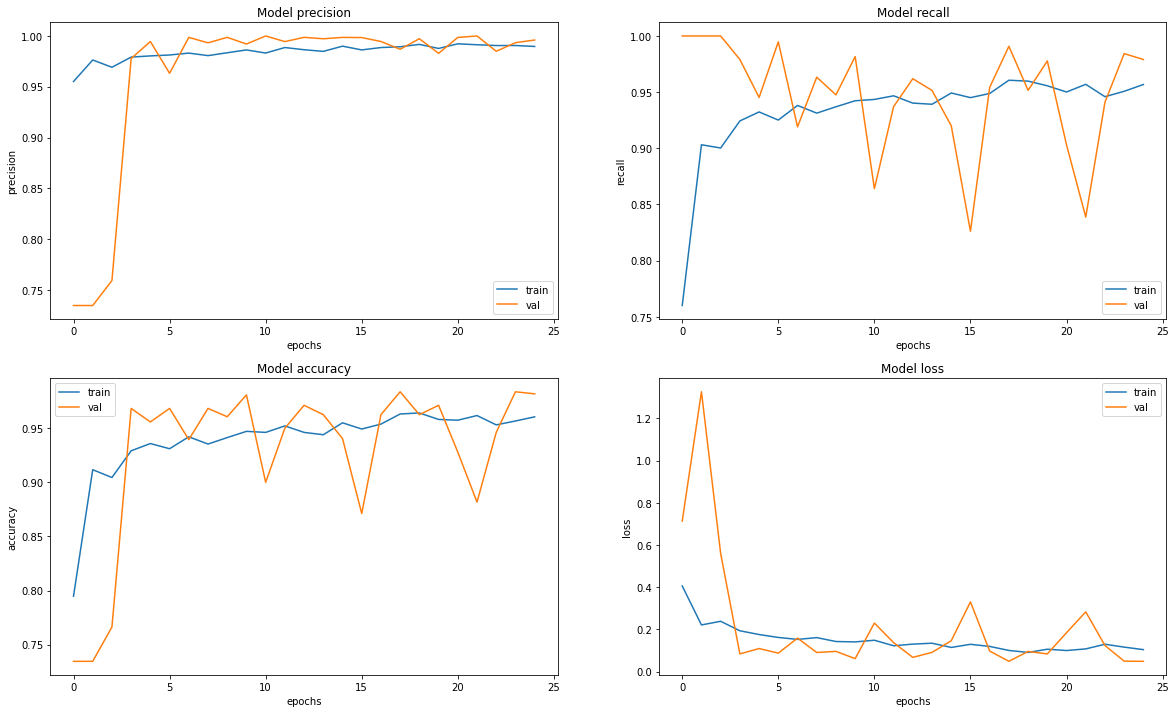

In [79]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [80]:
loss, acc, prec, rec = model.evaluate(test_ds)

326/326 [==============================] - 34s 103ms/step - loss: 0.0410 - accuracy: 0.9845 - precision: 0.9989 - recall: 0.9801


## 회고

- 의료영상 분야에서 어떤 식으로 활용되는지 확인 할 수 있는 시간이었다.
- 별다른 개선 없이 루브릭에서 요구한 85%를 달성하였다.
- Augmentation기법을 사용해 보았지만 눈에 띄는 성능 개선은 보이지 않았다
- 텐서플로에 대해서 완전하게 이해되지 않는 부분이 몇가지 있어서 남는 시간은 CNN 모델에 대한 이해와 텐서플로를 이해하는데 투자 하려고 한다.
- 본 프로젝트의 프로세스는 이해 됐으나 세부적인 코드의 구성과 작동방법에 대해서 아직 이해 되지 않는 부분이 존재한다. 역시 추가적으로 공부해서 이해하려고 한다. 
- 현재 1차 제출한 상태고 위에서 언급 한 것들을 추가적으로 공부한뒤 하이퍼 파라메터 또는 모델들을 변형하여 정확도를 좀더 높여 볼계획이다.
- 지금 변경해서 실험하려고 예상하고 있는 것들은 Convolution Layer의 filter의 크기, 배치사이즈, 드랍아웃, 이미지의 해상도 정도이다.
- 모델도 수정할 수 있다면 한번 시도해보고 싶기는 하지만 가능할지 ^^